<font color=red><p style="font-size:32px;text-align:center"><b>Products/Items Classification</b></p></font>

**<font color=blue>Data Overview</font>**
- training_data
- testing_data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv("training_data.csv")
test_data = pd.read_csv("testing_data.csv")

In [3]:
print("Training Data -",train_data.shape)
print("Testing Data -",test_data.shape)

Training Data - (20188, 2)
Testing Data - (10094, 2)


In [4]:
train_data.head()

,title,category
0,The Three Amigos,None
1,Home Essentials Blue Floral Glass Vintage Styl...,Home & Kitchen
2,Cooper Wiring Quiet Toggle Switch Single Pole ...,Tools & Home Improvement
3,Baseboarders&reg; Wall Brackets,Tools & Home Improvement
4,The Great Wave Off Kanagawa Custom Rectangle M...,Office Products


In [5]:
train_data['category'].value_counts()

None                        10123
Home & Kitchen               4960
Tools & Home Improvement     2080
Office Products              1144
Grocery & Gourmet Food       1102
Industrial & Scientific       588
Electronics                   191
Name: category, dtype: int64

In [6]:
#there are lots of None values
train_data.drop(train_data[train_data.category=='None'].index, inplace=True)

In [7]:
train_data['category'].value_counts()

Home & Kitchen              4960
Tools & Home Improvement    2080
Office Products             1144
Grocery & Gourmet Food      1102
Industrial & Scientific      588
Electronics                  191
Name: category, dtype: int64

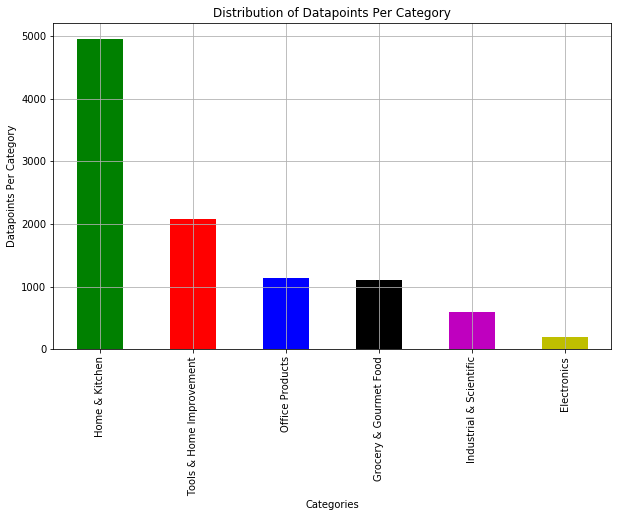

In [8]:
category_dist = train_data['category'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g', 'r', 'b', 'k', 'm', 'y']
category_dist.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("Categories")
plt.ylabel("Datapoints Per Category")
plt.title("Distribution of Datapoints Per Category")
plt.show()

**<font color=blue>Data Preprocessing</font>**

In [9]:
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import nltk
import re

#loading_the_stop_words_from_nltk_library_
stop_words = set(stopwords.words('english'))

def txt_preprocessing(total_text, index, column, df):
    if type(total_text) is not int:
        string = ""
        
        #replace_every_special_char_with_space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        #replace_multiple_spaces_with_single_space
        total_text = re.sub('\s+',' ', total_text)
        
        #converting_all_the_chars_into_lower_case
        total_text = total_text.lower()
        
        for word in total_text.split():
        #if_the_word_is_a_not_a_stop_word_then_retain_that_word_from_the_data
            if not word in stop_words:
                string += word + " "
        
        df[column][index] = string

In [10]:
#train_text_processing_stage_
for index, row in train_data.iterrows():
    if type(row['title']) is str:
        txt_preprocessing(row['title'], index, 'title', train_data)
    else:
        print("THERE IS NO TEXT DESCRIPTION FOR ID :",index)

train_data.head()

,title,category
1,home essentials blue floral glass vintage styl...,Home & Kitchen
2,cooper wiring quiet toggle switch single pole ...,Tools & Home Improvement
3,baseboarders reg wall brackets,Tools & Home Improvement
4,great wave kanagawa custom rectangle mouse pad...,Office Products
5,nemcor pittsburgh penguins nhl 1 ultimate fan ...,Home & Kitchen


In [11]:
#test_text_processing_stage_
for index, row in test_data.iterrows():
    if type(row['title']) is str:
        txt_preprocessing(row['title'], index, 'title', test_data)
    else:
        print("THERE IS NO TEXT DESCRIPTION FOR ID :",index)

test_data.head()

,title,category
0,pom pom hair band rabbit light grey decorative...,NaN
1,mariposa golf ball napkin weight,NaN
2,mediterranean snack food roasted garlic hummuz...,NaN
3,john deere 0071750gx22269 genuine original equ...,NaN
4,protech wood cleanr gl performance coatings in...,NaN


**<font color=blue>Train-Test Split</font>**

In [12]:
#split_your_data
from sklearn.model_selection import train_test_split
X_train = train_data['title']
y_train = train_data['category']

X_test = test_data['title']

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=0)

In [13]:
print("NUMBER OF DATA POINTS IN TRAIN DATA :", X_train.shape[0])
print("NUMBER OF DATA POINTS IN CROSS VALIDATION DATA :", X_cv.shape[0])

NUMBER OF DATA POINTS IN TRAIN DATA : 8052
NUMBER OF DATA POINTS IN CROSS VALIDATION DATA : 2013


**<font color=red>One Hot Encoding of Text Data (BoW)</font>**

In [14]:
#building a CountVectorizer with all the words that occured minimum 3 times in train data
from sklearn.feature_extraction.text import CountVectorizer

text_vectorizer = CountVectorizer(min_df=3)
train_text_ohe = text_vectorizer.fit_transform(X_train)

#getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

#train_text_ohe.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_ohe.sum(axis=0).A1

#zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total Number of Unique Words in Train Data :",len(train_text_features))

Total Number of Unique Words in Train Data : 4607


In [15]:
from sklearn.preprocessing import normalize #normalize every feature

train_text_ohe = normalize(train_text_ohe, axis=0)

#we use the same vectorizer that was trained on train data
test_text_ohe = text_vectorizer.transform(X_test)

#don't forget to normalize every feature
test_text_ohe = normalize(test_text_ohe, axis=0)

#we use the same vectorizer that was trained on train data
cv_text_ohe = text_vectorizer.transform(X_cv)

#don't forget to normalize every feature
cv_text_ohe = normalize(cv_text_ohe, axis=0)

In [16]:
print("Shape of Matrix After One Hot Encoding")
print(train_text_ohe.shape)
print(cv_text_ohe.shape)
print("-"*20)
print(test_text_ohe.shape)

Shape of Matrix After One Hot Encoding
(8052, 4607)
(2013, 4607)
--------------------
(10094, 4607)


**<font color=red>TFIDF of Text Data</font>**

In [17]:
#perform_tfidf_vectorization_of_text_data
from sklearn.feature_extraction.text import TfidfVectorizer

text_vec = TfidfVectorizer(min_df=10, max_features=5000)
text_vec.fit(X_train.values)

train_text = text_vec.transform(X_train.values)
test_text = text_vec.transform(X_test.values)
cv_text = text_vec.transform(X_cv.values)

print("Shape of Matrix - TFIDF")
print(train_text.shape)
print(test_text.shape)
print(cv_text.shape)

Shape of Matrix - TFIDF
(8052, 1471)
(10094, 1471)
(2013, 1471)


**<font color=blue>Confusion Matrix</font>**

In [18]:
#this_function_plots_the_confusion_matrices_given_y_i_and_y_i_hat_
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(test_y, predict_y):

    C = confusion_matrix(test_y, predict_y) #confusion_mat
    A =(((C.T)/(C.sum(axis=1))).T) #recall_mat
    B =(C/C.sum(axis=0)) #precision_mat
    
    labels = [1,2,3,4,5,6]
    
    #representing_C_in_heatmap_format
    print("-"*40, "Confusion Matrix", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #representing_B_in_heatmap_format
    print("-"*40, "Precision Matrix (Columm Sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #representing_A_in_heatmap_format
    print("-"*40, "Recall Matrix (Row Sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

**<h2><font color=red>1.a</font><font color=green> Logistic Regression</font></h2>**
- (One Hot Encoded Features)

For Values of Alpha = 1e-05 The Log Loss is: 0.5535709643872542
For Values of Alpha = 0.0001 The Log Loss is: 0.5558773952432869
For Values of Alpha = 0.001 The Log Loss is: 0.5731464502517174
For Values of Alpha = 0.01 The Log Loss is: 0.6161678785720365
For Values of Alpha = 0.1 The Log Loss is: 0.7975320838896389
For Values of Alpha = 1 The Log Loss is: 0.839149825623715


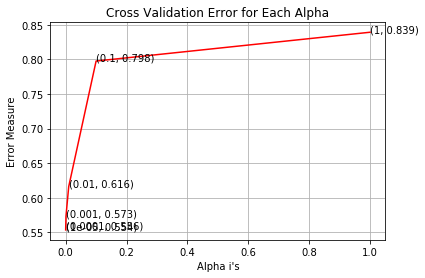

For Values of Best Alpha = 1e-05 The Train Log Loss is: 0.2333195262194634
For Values of Best Alpha = 1e-05 The Cross Validation Log Loss is: 0.5535709643872542


In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

#train a logistic regression + calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_ohe, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_ohe, y_train)
    
    predict_y = sig_clf.predict_proba(cv_text_ohe)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For Values of Alpha =',i,"The Log Loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_ohe, y_train)

lr_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
lr_sig_clf.fit(train_text_ohe, y_train)

predict_y = lr_sig_clf.predict_proba(train_text_ohe)
print('For Values of Best Alpha =', alpha[best_alpha],"The Train Log Loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = lr_sig_clf.predict_proba(cv_text_ohe)
print('For Values of Best Alpha =', alpha[best_alpha],"The Cross Validation Log Loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

In [20]:
from sklearn.metrics import accuracy_score
lr_train_accuracy = (lr_sig_clf.score(train_text_ohe, y_train)*100)
lr_cv_accuracy = (lr_sig_clf.score(cv_text_ohe, y_cv)*100)

print("Logistic Regression Train Accuracy -",lr_train_accuracy)
print("Logistic Regression CV Accuracy -",lr_cv_accuracy)

Logistic Regression Train Accuracy - 96.78340784898161
Logistic Regression CV Accuracy - 81.61947342275211


---------------------------------------- Confusion Matrix ----------------------------------------


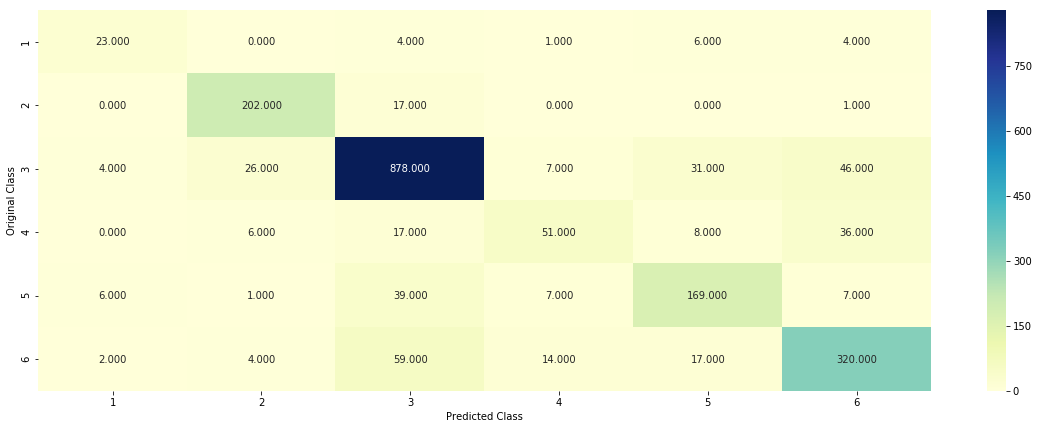

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


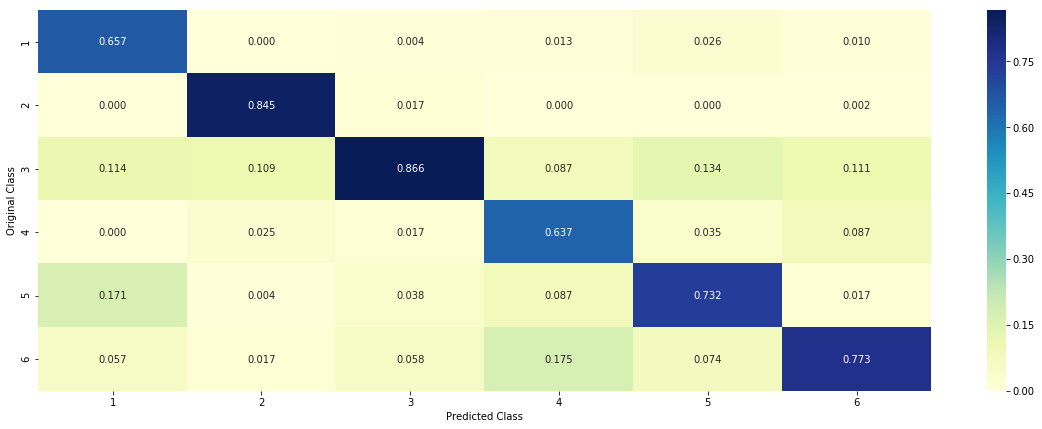

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


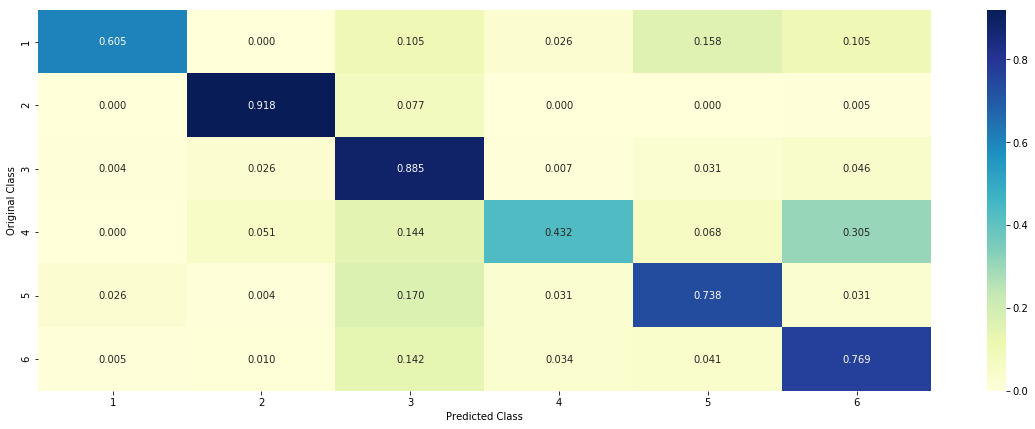

In [21]:
plot_confusion_matrix(y_cv, lr_sig_clf.predict(cv_text_ohe.toarray()))

**<h2><font color=red>1.b</font><font color=green> Multinomial Naive Bayes</font></h2>**
- (One Hot Encoded Features)

For Alpha = 1e-05
Log Loss : 0.7528751299426156
For Alpha = 0.0001
Log Loss : 0.7356989780886898
For Alpha = 0.001
Log Loss : 0.7072426830915849
For Alpha = 0.1
Log Loss : 0.6147357325457445
For Alpha = 1
Log Loss : 0.5953996418139288
For Alpha = 10
Log Loss : 0.6542903929688189
For Alpha = 100
Log Loss : 0.6853440153669194
For Alpha = 1000
Log Loss : 0.6897386561383198


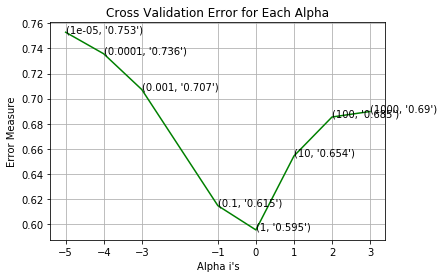

For Values of Best Alpha = 1 The Train Log Loss is: 0.42526511761457536
For Values of Best Alpha = 1 The Cross Validation Log Loss is: 0.5953996418139288


In [22]:
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]

cv_log_error_array = []

for i in alpha:
    print("For Alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_text_ohe, y_train)
    
    nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    nb_sig_clf.fit(train_text_ohe, y_train)
    
    sig_clf_probs = nb_sig_clf.predict_proba(cv_text_ohe)
    
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_text_ohe, y_train)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_ohe, y_train)

predict_y = nb_sig_clf.predict_proba(train_text_ohe)
print('For Values of Best Alpha =', alpha[best_alpha],"The Train Log Loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = nb_sig_clf.predict_proba(cv_text_ohe)
print('For Values of Best Alpha =', alpha[best_alpha], "The Cross Validation Log Loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

In [23]:
nb_train_accuracy = (nb_sig_clf.score(train_text_ohe, y_train)*100)
nb_cv_accuracy = (nb_sig_clf.score(cv_text_ohe, y_cv)*100)

print("Naive Bayes Train Accuracy -",nb_train_accuracy)
print("Naive Bayes CV Accuracy -",nb_cv_accuracy)

Naive Bayes Train Accuracy - 86.40089418777943
Naive Bayes CV Accuracy - 79.33432687531048


---------------------------------------- Confusion Matrix ----------------------------------------


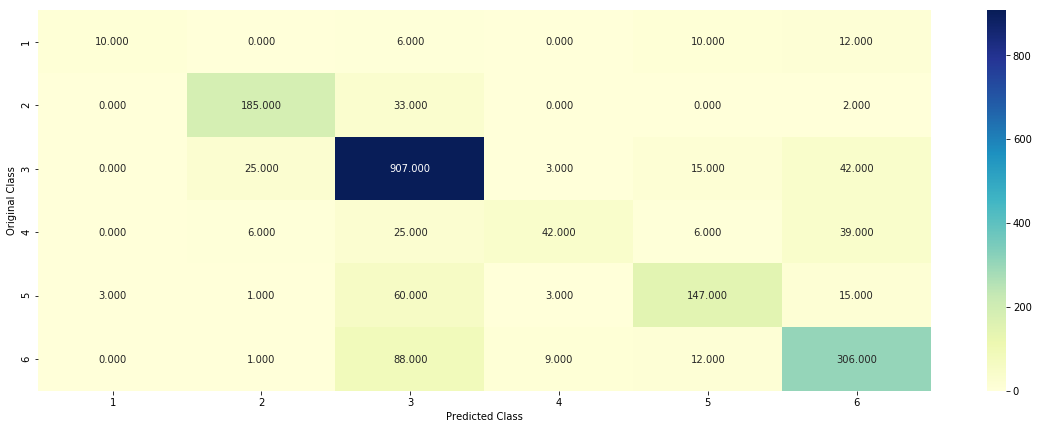

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


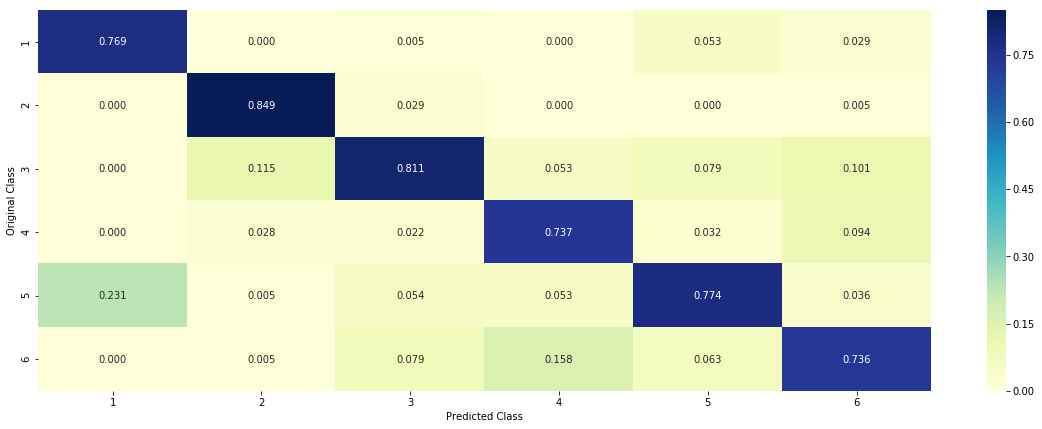

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


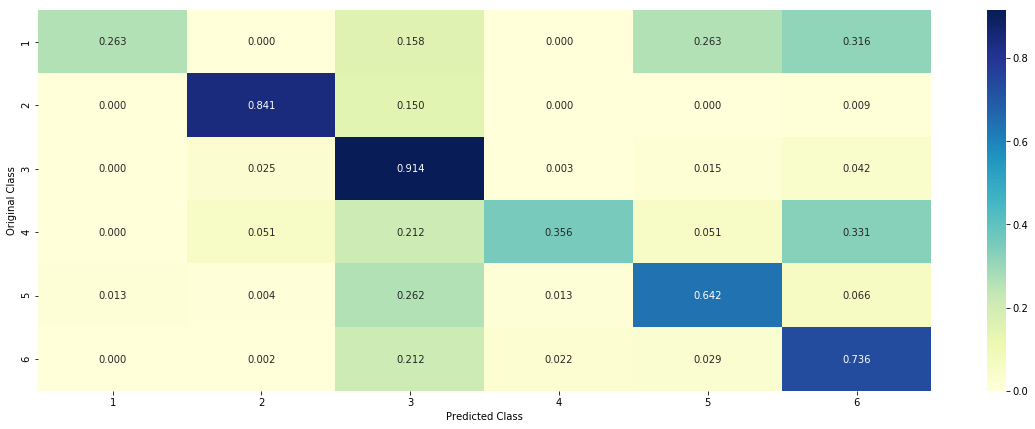

In [24]:
plot_confusion_matrix(y_cv, nb_sig_clf.predict(cv_text_ohe.toarray()))

**<h2><font color=red>2.a</font><font color=green> Logistic Regression</font></h2>**
- (TFIDF Features)

For Values of Alpha = 1e-05 The Log Loss is: 0.6196350132854808
For Values of Alpha = 0.0001 The Log Loss is: 0.6001370123242793
For Values of Alpha = 0.001 The Log Loss is: 0.6925960194695843
For Values of Alpha = 0.01 The Log Loss is: 0.8501857031554926
For Values of Alpha = 0.1 The Log Loss is: 1.0262452082839038
For Values of Alpha = 1 The Log Loss is: 1.058556393794561


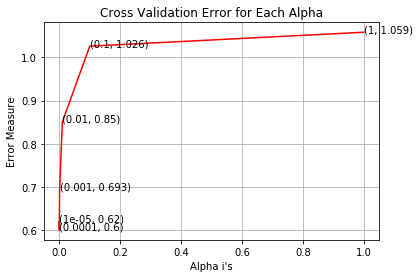

For Values of Best Alpha = 0.0001 The Train Log Loss is: 0.42187341561499697
For Values of Best Alpha = 0.0001 The Cross Validation Log Loss is: 0.6001370123242793


In [25]:
#train a logistic regression + calibration model using text features which are tfidf encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text, y_train)
    
    predict_y = sig_clf.predict_proba(cv_text)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For Values of Alpha =',i,"The Log Loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text, y_train)

lr2_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
lr2_sig_clf.fit(train_text, y_train)

predict_y = lr2_sig_clf.predict_proba(train_text)
print('For Values of Best Alpha =', alpha[best_alpha],"The Train Log Loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = lr2_sig_clf.predict_proba(cv_text)
print('For Values of Best Alpha =', alpha[best_alpha],"The Cross Validation Log Loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

In [26]:
lr2_train_accuracy = (lr2_sig_clf.score(train_text, y_train)*100)
lr2_cv_accuracy = (lr2_sig_clf.score(cv_text, y_cv)*100)

print("Logistic Regression Train Accuracy -",lr2_train_accuracy)
print("Logistic Regression CV Accuracy -",lr2_cv_accuracy)

Logistic Regression Train Accuracy - 86.8976651763537
Logistic Regression CV Accuracy - 78.53949329359166


---------------------------------------- Confusion Matrix ----------------------------------------


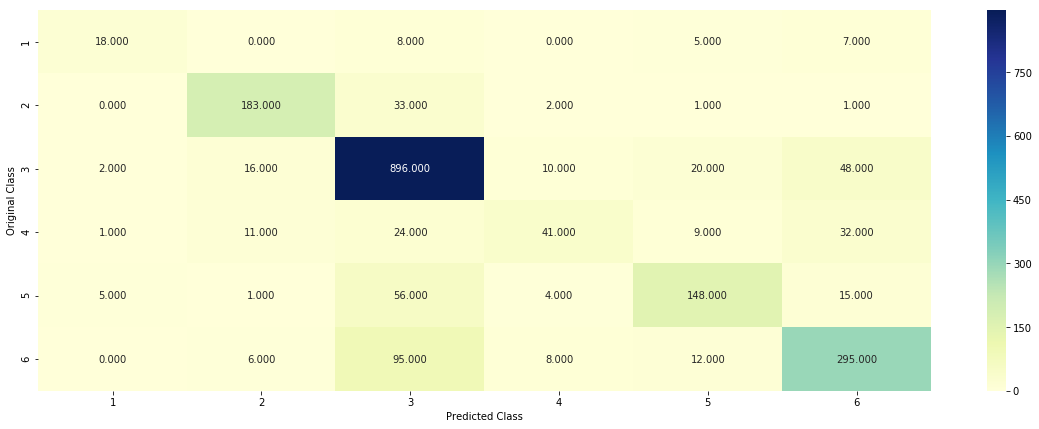

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


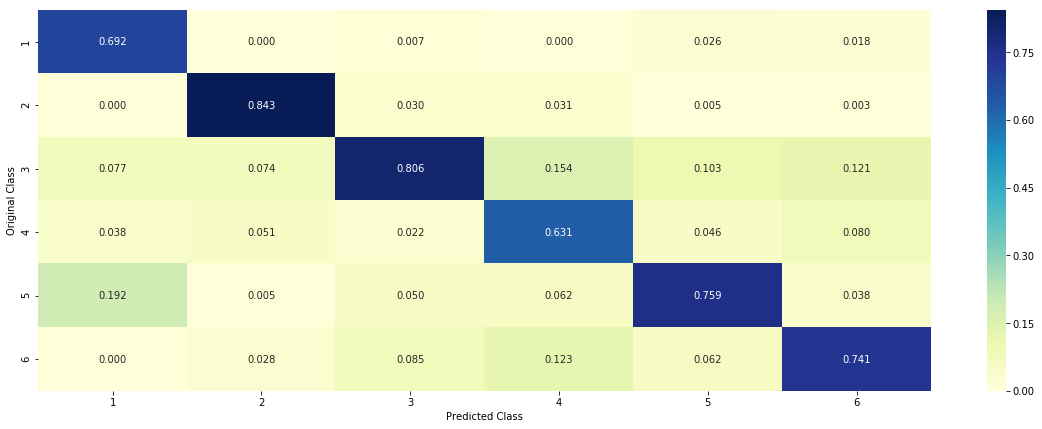

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


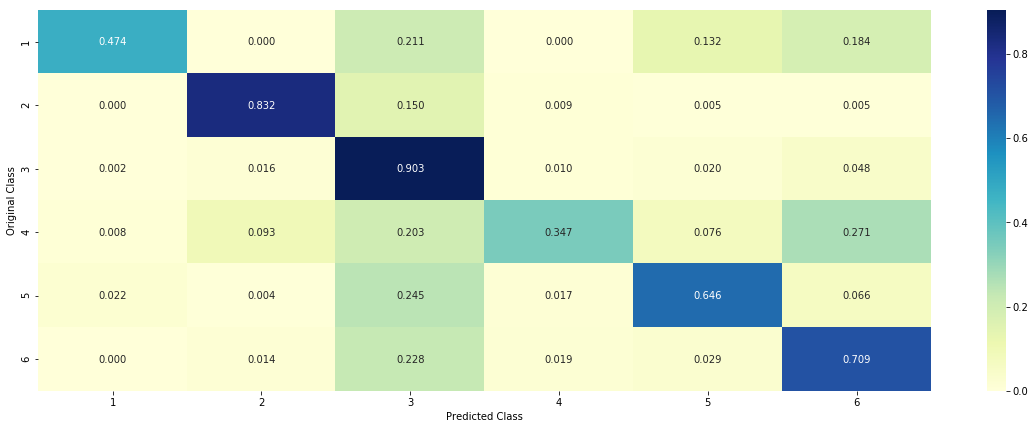

In [27]:
plot_confusion_matrix(y_cv, lr2_sig_clf.predict(cv_text.toarray()))

**<h2><font color=red>2.b</font><font color=green> Multinomial Naive Bayes</font></h2>**
- (TFIDF Features)

For Alpha = 1e-05
Log Loss : 0.7182194533290541
For Alpha = 0.0001
Log Loss : 0.701440265828476
For Alpha = 0.001
Log Loss : 0.6756582776720937
For Alpha = 0.1
Log Loss : 0.6139759314968224
For Alpha = 1
Log Loss : 0.6270448788004639
For Alpha = 10
Log Loss : 0.7619380359545495
For Alpha = 100
Log Loss : 0.9495913907061101
For Alpha = 1000
Log Loss : 1.0185239185824317


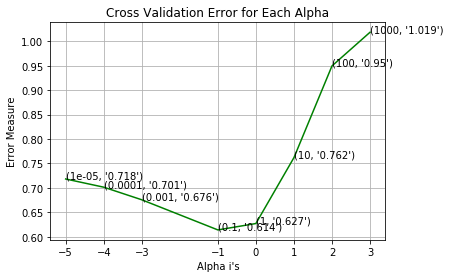

For Values of Best Alpha = 0.1 The Train Log Loss is: 0.44061834866966454
For Values of Best Alpha = 0.1 The Cross Validation Log Loss is: 0.6139759314968224


In [28]:
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]

cv_log_error_array = []

for i in alpha:
    print("For Alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_text, y_train)
    
    nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    nb_sig_clf.fit(train_text, y_train)
    
    sig_clf_probs = nb_sig_clf.predict_proba(cv_text)
    
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_text, y_train)

nb2_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb2_sig_clf.fit(train_text, y_train)

predict_y = nb2_sig_clf.predict_proba(train_text)
print('For Values of Best Alpha =', alpha[best_alpha],"The Train Log Loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = nb2_sig_clf.predict_proba(cv_text)
print('For Values of Best Alpha =', alpha[best_alpha], "The Cross Validation Log Loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

In [29]:
nb2_train_accuracy = (nb2_sig_clf.score(train_text, y_train)*100)
nb2_cv_accuracy = (nb2_sig_clf.score(cv_text, y_cv)*100)

print("Naive Bayes Train Accuracy -",nb2_train_accuracy)
print("Naive Bayes CV Accuracy -",nb2_cv_accuracy)

Naive Bayes Train Accuracy - 85.82960755091904
Naive Bayes CV Accuracy - 78.9865871833085


---------------------------------------- Confusion Matrix ----------------------------------------


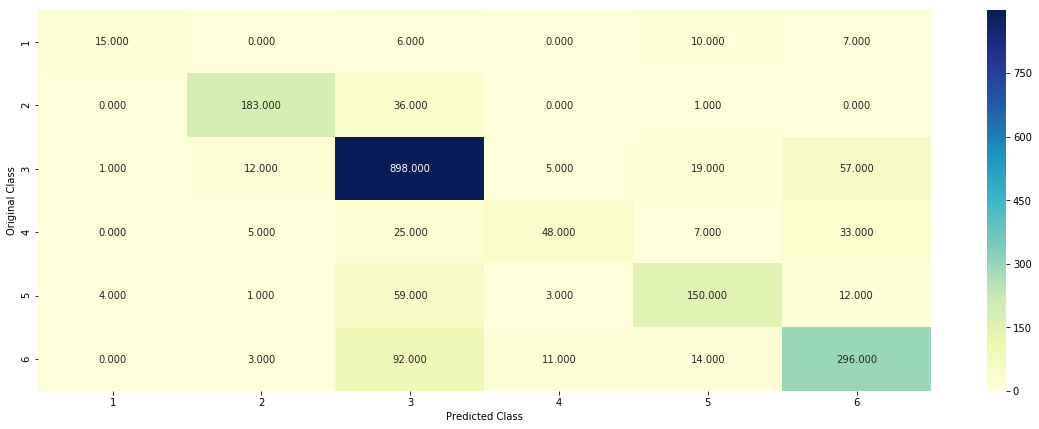

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


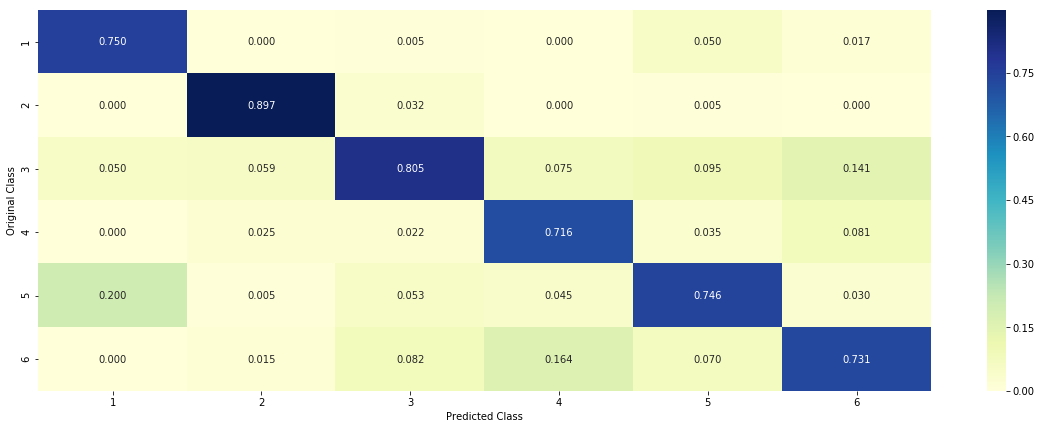

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


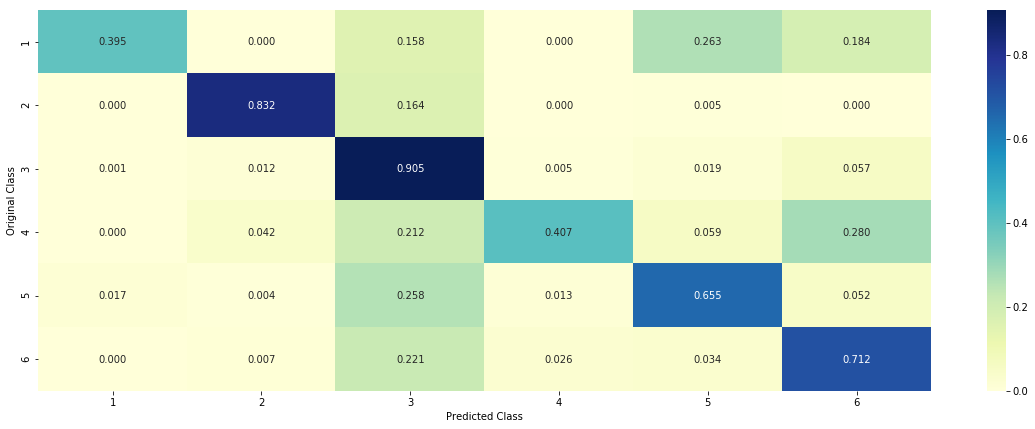

In [30]:
plot_confusion_matrix(y_cv, nb2_sig_clf.predict(cv_text.toarray()))

**<font color=red>Pretty Table</font>**

In [31]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "Train Accuracy Score" , "CV Accuracy Score"]
x.add_row(['Logistic Regression (BoW)', round(lr_train_accuracy, 2), round(lr_cv_accuracy, 2)])
x.add_row(['Multinomial Naive Bayes (BoW)', round(nb_train_accuracy, 2), round(nb_cv_accuracy, 2)])
x.add_row(['Logistic Regression (TFIDF)', round(lr2_train_accuracy, 2), round(lr2_cv_accuracy, 2)])
x.add_row(['Multinomial Naive Bayes (TFIDF)', round(nb2_train_accuracy, 2), round(nb2_cv_accuracy, 2)])
print(x)

+---------------------------------+----------------------+-------------------+
|              Model              | Train Accuracy Score | CV Accuracy Score |
+---------------------------------+----------------------+-------------------+
|    Logistic Regression (BoW)    |        96.78         |       81.62       |
|  Multinomial Naive Bayes (BoW)  |         86.4         |       79.33       |
|   Logistic Regression (TFIDF)   |         86.9         |       78.54       |
| Multinomial Naive Bayes (TFIDF) |        85.83         |       78.99       |
+---------------------------------+----------------------+-------------------+


_From the above table it seems that, Logistic Regression Model on BoW works quite well as compared to other models. So we will apply Logistic Regression on given Testing dataset._

In [32]:
test_pred = lr_sig_clf.predict(test_text_ohe) #it returns an array and we need to convert it into the list
test_pred_list = test_pred.tolist()
test_pred_list[:5]

['Home & Kitchen',
 'Home & Kitchen',
 'Grocery & Gourmet Food',
 'Industrial & Scientific',
 'Home & Kitchen']

In [33]:
#load given test file and create new final dataset
test_dataset = pd.read_csv("testing_data.csv")
test_dataset.head()

,title,category
0,Pom Pom Hair Band Rabbit Light Grey Decorative...,NaN
1,Mariposa Golf Ball Napkin Weight,NaN
2,Mediterranean Snack Food Roasted Garlic Hummuz...,NaN
3,John Deere 0071750GX22269 Genuine Original Equ...,NaN
4,"Protech Wood Cleanr Gl,PERFORMANCE COATINGS IN...",NaN


In [36]:
final_test_df = pd.DataFrame({'Title':test_dataset['title'], 'Category':test_pred_list})

In [37]:
final_test_df.head(10)

,Title,Category
0,Pom Pom Hair Band Rabbit Light Grey Decorative...,Home & Kitchen
1,Mariposa Golf Ball Napkin Weight,Home & Kitchen
2,Mediterranean Snack Food Roasted Garlic Hummuz...,Grocery & Gourmet Food
3,John Deere 0071750GX22269 Genuine Original Equ...,Industrial & Scientific
4,"Protech Wood Cleanr Gl,PERFORMANCE COATINGS IN...",Home & Kitchen
5,tic tac Holiday Candy Cane and Cherry Apple Tw...,Grocery & Gourmet Food
6,DENIED Red Office Stock Self-Inking Rubber Stamp,Office Products
7,Replacement Message Board Face with Tracks for...,Office Products
8,Bundle - 3 Items: Sweet Baby Ray's Buffalo Win...,Grocery & Gourmet Food
9,BravoVision Fashion Custom Chicago Scenery Wat...,Home & Kitchen
